In [80]:
import networkx as nx
import numpy as np
import powerlaw
import json
import glob
import os

In [81]:
# Load gml file
G = nx.read_gml("../Graphs/mention_network_earliest.gml")

In [82]:
# Compute the average, median, mode, minimum and maximum value of the in-degree and out-degree
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

avg_in_degree = sum(in_degrees) / len(in_degrees)
avg_out_degree = sum(out_degrees) / len(out_degrees)
median_in_degree = np.median(in_degrees)
median_out_degree = np.median(out_degrees)
min_in_degree = min(in_degrees)
min_out_degree = min(out_degrees)
max_in_degree = max(in_degrees)
max_out_degree = max(out_degrees)

print("In-Degree statistics:")
print("---------------------")
print(f"Average: {avg_in_degree}")
print(f"Median: {median_in_degree}")
print(f"Minimum: {min_in_degree}")
print(f"Maximum: {max_in_degree}\n")

print("Out-Degree statistics:")
print("----------------------")
print(f"Average: {avg_out_degree}")
print(f"Median: {median_out_degree}")
print(f"Minimum: {min_out_degree}")
print(f"Maximum: {max_out_degree}")


In-Degree statistics:
---------------------
Average: 14.113490364025695
Median: 4.0
Minimum: 0
Maximum: 293

Out-Degree statistics:
----------------------
Average: 14.113490364025695
Median: 11.0
Minimum: 0
Maximum: 72


In [83]:
# print the streamers with highest in-degrees and out-degrees
sorted_in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)
sorted_out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)

print("\nTop 5 Streamers by In-Degree:")
print("-----------------------------")
for i, (streamer, degree) in enumerate(sorted_in_degrees[:5]):
    print(f"{i+1}. {streamer}: {degree}")

print("\nTop 5 Streamers by Out-Degree:")
print("------------------------------")
for i, (streamer, degree) in enumerate(sorted_out_degrees[:5]):
    print(f"{i+1}. {streamer}: {degree}")


Top 5 Streamers by In-Degree:
-----------------------------
1. smoke: 293
2. bugs: 215
3. ninja: 213
4. halo: 164
5. xqc: 150

Top 5 Streamers by Out-Degree:
------------------------------
1. yourragegaming: 72
2. erobb221: 69
3. fandy: 69
4. xqc: 65
5. zackrawrr: 62


#### Powerlaw
Power laws indicate whether a system is highly unequal: most nodes have few connections, while a small number act as hubs. Detecting a power law helps reveal if the network’s structure is shaped by self-reinforcing dynamics such as preferential attachment.

In [84]:
# Fit powerlaw distributions to in-degrees, out-degrees, and total degrees
total_degrees = in_degrees + out_degrees
fit_total = powerlaw.Fit(total_degrees, discrete=True)
fit_in = powerlaw.Fit(in_degrees, discrete=True)
fit_out = powerlaw.Fit(out_degrees, discrete=True)

print("\nPowerlaw Fit Results:")
print("---------------------")
print(f"Total Degrees: alpha = {fit_total.alpha:.4f}, xmin = {fit_total.xmin}")
print(f"In-Degrees: alpha = {fit_in.alpha:.4f}, xmin = {fit_in.xmin}")
print(f"Out-Degrees: alpha = {fit_out.alpha:.4f}, xmin = {fit_out.xmin}")


Powerlaw Fit Results:
---------------------
Total Degrees: alpha = 2.7305, xmin = 20.0
In-Degrees: alpha = 2.1021, xmin = 19.0
Out-Degrees: alpha = 3.6945, xmin = 20.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


For the total degree, we find an exponent of $γ ≈ 2.83,$ which lies within the classic scale-free regime $2 < \gamma < 3$. Networks in this range naturally form hubs: a small number of streamers become globally central and are referenced frequently, while the majority have relatively modest degree. This indicates that attention on Twitch is not evenly distributed but is concentrated around a few key streamers.



For the in-degree, the exponent is $γ ≈ 1.81$, which is even lower than what is typically observed in social or information networks. Exponents below 2 indicate an extremely heavy-tailed distribution, meaning the network is dominated by a few very large hubs. In this case, a small group of streamers receives a disproportionately large share of all mentions. Such a low exponent strongly suggests preferential attachment is unusually pronounced: the more a streamer is mentioned, the more likely they are to be mentioned again. This is a clear example of a rich-get-richer or popularity-driven dynamic.



In contrast, the out-degree has an exponent of $γ ≈ 3.9$, which is relatively steep. Exponents above 3 imply that hubs are essentially absent in the outgoing direction. This means most streamers’ chats mention only a small number of other streamers, and very few mention many others. Out-degree is therefore not heavy-tailed, reflecting that chat discussions tend to focus on a limited set of other streamers and do not produce large broadcaster-like “outgoing hubs.”



The strong asymmetry between in-degree and out-degree likely reflects how attention flows on Twitch. A few streamers are mentioned far more than others because their names are frequently brought up on-stream, amplified by chat reactions, collaborations, etc.

#### Lenght of chats

We also examine the lenght of the chats. There are two questions of interest:

1. Total number of messages logged for that channel during the window.

2. Average number of words/characters per message

In [85]:
import json
from pathlib import Path

# Setup path to chat files
files_dir = Path("../Proj3/mention_network_chats/")

for node in G.nodes():
    
    matches = list(files_dir.glob(f"{node.capitalize()}_*.json"))
    if not matches:
        matches = list(files_dir.glob(f"{node}_*.json"))
    
    if not matches:
        continue

    try:
        with open(matches[0], 'r', encoding='utf-8') as f:
            data = json.load(f)
    except (OSError, json.JSONDecodeError) as e:
        print(f"Error loading {node}: {e}")
        continue

    
    messages = data.get('comments', [])
    count = len(messages)
    
    
    if count > 0:
        total_words = 0
        total_chars = 0
        
        for msg in messages:
            
            msg_body = msg.get('message', {})
            if isinstance(msg_body, dict):
                text = msg_body.get('body', "")
            else:
                text = "" # Fallback
            
            total_words += len(text.split())
            total_chars += len(text)
            
        avg_word_len = total_words / count
        avg_char_len = total_chars / count
    else:
        avg_word_len = 0
        avg_char_len = 0

   
    G.nodes[node]['msg_count'] = count
    G.nodes[node]['avg_word_len'] = avg_word_len
    G.nodes[node]['avg_char_len'] = avg_char_len


Error loading jasontheween: Expecting value: line 1 column 1 (char 0)


In [86]:
print("\nTop 5 Streamers by Message Count:")
print("-------------------------------")

sorted_msg_counts = sorted(G.nodes(data=True), key=lambda x: x[1].get('msg_count', 0), reverse=True)

for i, (streamer, attrs) in enumerate(sorted_msg_counts[:5]):
    count = attrs.get('msg_count', 0)
    print(f"{i+1}. {streamer}: {count} messages")


print("\nTop 5 Streamers by Average Word Count:")
print("-----------------------------")
sorted_word_counts = sorted(G.nodes(data=True), key=lambda x: x[1].get('avg_word_len', 0), reverse=True)

for i, (streamer, attrs) in enumerate(sorted_word_counts[:5]):
    count = attrs.get('avg_word_len', 0)
    print(f"{i+1}. {streamer}: {count:.2f} words")


print("\nTop 5 Streamers by Average Character Count:")
print("-----------------------------")
sorted_char_counts = sorted(G.nodes(data=True), key=lambda x: x[1].get('avg_char_len', 0), reverse=True)

for i, (streamer, attrs) in enumerate(sorted_char_counts[:5]):
    count = attrs.get('avg_char_len', 0)
    print(f"{i+1}. {streamer}: {count:.2f} characters")


Top 5 Streamers by Message Count:
-------------------------------
1. hasanabi: 284840 messages
2. adapt: 255158 messages
3. xqc: 218448 messages
4. ddg: 147004 messages
5. caedrel: 140040 messages

Top 5 Streamers by Average Word Count:
-----------------------------
1. realzbluewater: 17.93 words
2. shrood: 9.32 words
3. moxsy: 9.17 words
4. stonemountain64: 9.11 words
5. xop0: 9.01 words

Top 5 Streamers by Average Character Count:
-----------------------------
1. realzbluewater: 141.37 characters
2. rockykramer: 83.61 characters
3. asianbunnyx: 66.66 characters
4. shrood: 55.52 characters
5. stonemountain64: 53.74 characters


In [87]:
import networkx as nx
from scipy.stats import spearmanr
import numpy as np

# 1. Prepare data for correlation analysis
# We extract message counts, in-degrees, and out-degrees for nodes with msg_count
data = [
    (G.nodes[n].get('msg_count', 0), G.in_degree(n), G.out_degree(n))
    for n in G.nodes()
    if G.nodes[n].get('msg_count', 0) > 0
]

if data:
    message_counts_filtered, in_degrees_filtered, out_degrees_filtered = zip(*data)

    # 2. Calculate Spearman Correlation
    # We use Spearman because message counts and degrees likely follow a power law (non-linear)
    rho_in_corr_mc, p_val_in = spearmanr(in_degrees_filtered, message_counts_filtered)
    rho_out_corr_mc, p_val_out = spearmanr(out_degrees_filtered, message_counts_filtered)

    print("\n--- Spearman Correlation (Volume Analysis) ---")
    print(f"In-Degree vs. Message Count: {rho_in_corr_mc:.4f} (p-value: {p_val_in:.4f})")
    print(f"Out-Degree vs. Message Count: {rho_out_corr_mc:.4f} (p-value: {p_val_out:.4f})")
    
    # Interpretation hint printed for convenience
    if rho_in_corr_mc > 0.5:
        print(">> Strong positive correlation: High In-Degree (popularity) relates to more chat activity.")
else:
    print("No nodes found with message counts > 0.")


--- Spearman Correlation (Volume Analysis) ---
In-Degree vs. Message Count: 0.2778 (p-value: 0.0000)
Out-Degree vs. Message Count: 0.4762 (p-value: 0.0000)


In [88]:
# 1. Filter and Align Data for Linguistic Analysis
# Extract 'avg_word_len' directly from the graph nodes.
# We only include nodes where the average word length is greater than 0.
data_linguistic = [
    (G.nodes[n].get('avg_word_len', 0), G.in_degree(n), G.out_degree(n))
    for n in G.nodes()
    if G.nodes[n].get('avg_word_len', 0) > 0
]

if data_linguistic:
    word_counts_filtered, in_degrees_filtered, out_degrees_filtered = zip(*data_linguistic)

    # 2. Calculate Spearman Correlation
    rho_in_corr_wc, p_val_in_wc = spearmanr(in_degrees_filtered, word_counts_filtered)
    rho_out_corr_wc, p_val_out_wc = spearmanr(out_degrees_filtered, word_counts_filtered)

    print("\n--- Spearman Correlation (Linguistic Analysis) ---")
    print(f"In-Degree vs. Avg Word Count: {rho_in_corr_wc:.4f} (p-value: {p_val_in_wc:.4f})")
    print(f"Out-Degree vs. Avg Word Count: {rho_out_corr_wc:.4f} (p-value: {p_val_out_wc:.4f})")
    
    # Optional interpretation
    if rho_in_corr_wc < 0:
        print(">> Negative correlation: Popular streamers (high In-Degree) tend to have shorter messages (spam/emotes).")
else:
    print("No nodes found with valid word count data.")


--- Spearman Correlation (Linguistic Analysis) ---
In-Degree vs. Avg Word Count: -0.2119 (p-value: 0.0000)
Out-Degree vs. Avg Word Count: -0.3499 (p-value: 0.0000)
>> Negative correlation: Popular streamers (high In-Degree) tend to have shorter messages (spam/emotes).


In [89]:
# 1. Filter and Align Data for Character Analysis
# Extract 'avg_char_len' directly from the graph nodes.
data_chars = [
    (G.nodes[n].get('avg_char_len', 0), G.in_degree(n), G.out_degree(n))
    for n in G.nodes()
    if G.nodes[n].get('avg_char_len', 0) > 0
]

if data_chars:
    char_counts_filtered, in_degrees_filtered, out_degrees_filtered = zip(*data_chars)

    # 2. Calculate Spearman Correlation
    rho_in_corr_cc, p_val_in_cc = spearmanr(in_degrees_filtered, char_counts_filtered)
    rho_out_corr_cc, p_val_out_cc = spearmanr(out_degrees_filtered, char_counts_filtered)

    print("\n--- Spearman Correlation (Character Analysis) ---")
    print(f"In-Degree vs. Avg Character Count: {rho_in_corr_cc:.4f} (p-value: {p_val_in_cc:.4f})")
    print(f"Out-Degree vs. Avg Character Count: {rho_out_corr_cc:.4f} (p-value: {p_val_out_cc:.4f})")
    
    # Interpretation hint
    if rho_in_corr_cc < 0:
        print(">> Negative correlation: Popular channels tend to have shorter messages (more spam/emotes).")
    elif rho_in_corr_cc > 0:
        print(">> Positive correlation: Popular channels tend to have longer, more complex discussions.")
else:
    print("No nodes found with valid character count data.")


--- Spearman Correlation (Character Analysis) ---
In-Degree vs. Avg Character Count: -0.2398 (p-value: 0.0000)
Out-Degree vs. Avg Character Count: -0.3767 (p-value: 0.0000)
>> Negative correlation: Popular channels tend to have shorter messages (more spam/emotes).


Analyzing the correlations we see a strong positive correlation between Out-Degree and Message Count ($\rho \approx +0.47$). It confirms that the activity and scale (Volume) is the primary driver of a streamer's outgoing influence (Out-Degree) within the network. Streamers with the highest volume are the most connected and active hubs in the network. Furthermore, for the lingustic analysis, both correlations are negative, this suggest that network centrality inversely correlates with linguistic complexity. As a streamer's influence (especially Out-Degree, $\rho \approx -0.37$) increases, the average word count in their chat decreases. This suggests that the streams acting as major hubs and bridges in the network tend to foster simplistic, rapid-fire communication, indicating that broad structural influence comes at the cost of verbose discussion. 

#### Centrality

##### Betweenness Centrality

In [90]:
import networkx as nx
from scipy.stats import spearmanr

# 1. Calculate Betweenness Centrality
print("Calculating Betweenness Centrality...")
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

# 2. Filter and Align Data
# We extract data directly from the graph attributes and the calculated centrality.
# We only include nodes that have valid chat data (msg_count > 0).
data_betweenness = [
    (
        betweenness_centrality.get(n, 0),      # Centrality
        G.nodes[n].get('msg_count', 0),        # Message Volume
        G.nodes[n].get('avg_word_len', 0),     # Word Length
        G.nodes[n].get('avg_char_len', 0)      # Character Length
    )
    for n in G.nodes()
    if G.nodes[n].get('msg_count', 0) > 0
]

# 3. Calculate Spearman Correlations
if data_betweenness:
    
    bc_filtered, mc_filtered, wc_filtered, cc_filtered = zip(*data_betweenness)

    # Calculate correlations (including p-values for statistical significance)
    rho_bc_mc, p_bc_mc = spearmanr(bc_filtered, mc_filtered)
    rho_bc_wc, p_bc_wc = spearmanr(bc_filtered, wc_filtered)
    rho_bc_cc, p_bc_cc = spearmanr(bc_filtered, cc_filtered)

    print("\n--- Betweenness Centrality Correlations ---")
    print(f"Betweenness vs. Message Count:    {rho_bc_mc:.4f} (p-value: {p_bc_mc:.4f})")
    print(f"Betweenness vs. Avg Word Count:   {rho_bc_wc:.4f} (p-value: {p_bc_wc:.4f})")
    print(f"Betweenness vs. Avg Char Count:   {rho_bc_cc:.4f} (p-value: {p_bc_cc:.4f})")
    
    # Interpretation hint
    if rho_bc_cc > 0.1:
        print(">> Observation: Connectors (high betweenness) tend to have longer/more complex messages.")
    elif rho_bc_cc < -0.1:
        print(">> Observation: Connectors tend to use shorter messages/emotes.")
else:
    print("No valid nodes found for correlation analysis.")

Calculating Betweenness Centrality...

--- Betweenness Centrality Correlations ---
Betweenness vs. Message Count:    0.2907 (p-value: 0.0000)
Betweenness vs. Avg Word Count:   -0.1858 (p-value: 0.0001)
Betweenness vs. Avg Char Count:   -0.2200 (p-value: 0.0000)
>> Observation: Connectors tend to use shorter messages/emotes.


We see a positve correlation with betweeness Centrality and message count and a negative correlation with the average word count, suggesting the streamers with the greatest structural importance for the cohesion of the Twitch network (high Betweenness Centrality) are characterized by high volume of messages and low linguistic complexity. They function as busy, easily accessible hubs that enable fast and simple information exchange.

##### Eigenvector Centrality

In [91]:
import networkx as nx
from scipy.stats import spearmanr

# 1. Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# 2. Filter and Align Data
data_eigen = [
    (
        eigenvector_centrality.get(n, 0),      # Centrality
        G.nodes[n].get('msg_count', 0),        # Message Volume
        G.nodes[n].get('avg_word_len', 0),     # Word Length
        G.nodes[n].get('avg_char_len', 0)      # Character Length
    )
    for n in G.nodes()
    if G.nodes[n].get('msg_count', 0) > 0
]

if data_eigen:
    # Unzip data
    ec_filtered, mc_filtered, wc_filtered, cc_filtered = zip(*data_eigen)

    # 3. Calculate Spearman Correlations
    rho_ec_mc, p_ec_mc = spearmanr(ec_filtered, mc_filtered)
    rho_ec_wc, p_ec_wc = spearmanr(ec_filtered, wc_filtered)
    rho_ec_cc, p_ec_cc = spearmanr(ec_filtered, cc_filtered)

    print("\n--- Eigenvector Centrality Correlations ---")
    print(f"Eigenvector vs. Message Count:    {rho_ec_mc:.4f} (p-value: {p_ec_mc:.4f})")
    print(f"Eigenvector vs. Avg Word Count:   {rho_ec_wc:.4f} (p-value: {p_ec_wc:.4f})")
    print(f"Eigenvector vs. Avg Char Count:   {rho_ec_cc:.4f} (p-value: {p_ec_cc:.4f})")

    # Interpretation
    if rho_ec_mc > 0.5:
        print(">> Analysis: High 'Prestige' (Eigenvector) strongly correlates with chat volume.")
else:
    print("No valid data found for Eigenvector analysis.")


--- Eigenvector Centrality Correlations ---
Eigenvector vs. Message Count:    0.3312 (p-value: 0.0000)
Eigenvector vs. Avg Word Count:   -0.2526 (p-value: 0.0000)
Eigenvector vs. Avg Char Count:   -0.2717 (p-value: 0.0000)


#### Communities

First we find the partitions

In [92]:
from community import community_louvain # from the python-louvain library
import matplotlib.pyplot as plt

G_undir = G.to_undirected()
partition = community_louvain.best_partition(G_undir)
modularity = community_louvain.modularity(partition, G_undir)


print("\n--- Community Detection ---")
print(f"Modularity Score (Q): {modularity:.4f}")
print(f"Number of Communities Detected: {len(set(partition.values()))}")


--- Community Detection ---
Modularity Score (Q): 0.6361
Number of Communities Detected: 19


Next we find some statistics for the communities

Average Community Size: 24.58
Median Community Size: 12.00
Minimum Community Size: 1
Maximum Community Size: 128
number of communities with size 1: 6


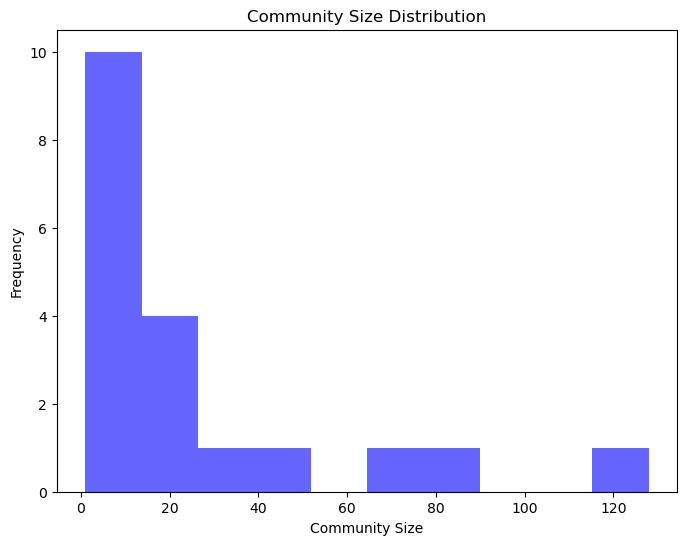

In [93]:
# community statistics
community_sizes = {}
for comm in set(partition.values()):
    community_sizes[comm] = list(partition.values()).count(comm)
size_values = list(community_sizes.values())
print(f"Average Community Size: {np.mean(size_values):.2f}")
print(f"Median Community Size: {np.median(size_values):.2f}")
print(f"Minimum Community Size: {np.min(size_values)}")
print(f"Maximum Community Size: {np.max(size_values)}")
print(f"number of communities with size 1: {list(size_values).count(1)}")

# Plot community size distribution
plt.figure(figsize=(8, 6))
plt.hist(size_values, bins=10, color='blue', alpha=0.6)
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.show()

From the communities we can see a high modularity score, which indicates a strong membership structure, meaning the top twitch streamers show strong and robust clustering which is not random. This means similar streamers tend to link to eachother. However, 6 of the 19 communities only have one member and are isolates. 

Next lets look at the lingustics are in the communities of the top 5 largest communities

In [99]:
import numpy as np

# Select largest communities (>10 members)
selected_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:10]

print(f"{'Comm ID':<10} | {'Main Leader':<20} | {'Size':<6} | {'Avg Word Len':<12} | {'Avg Char Len'}")
print("-" * 80)

for comm in selected_communities:
    # 1. Identify Members
    members = [node for node in partition if partition[node] == comm]
    
    # 2. Find the Structural Leader (Highest Degree in Subgraph)
    subgraph = G_undir.subgraph(members)
    degrees = subgraph.degree()
    # Sort by degree, get the top one
    leader = sorted(degrees, key=lambda x: x[1], reverse=True)[0][0]
    
    # 3. Aggregate Linguistic Metrics for the WHOLE community
    # We only include members that actually have chat data (msg_count > 0)
    word_lens = [G.nodes[n].get('avg_word_len', 0) for n in members if G.nodes[n].get('msg_count', 0) > 0]
    char_lens = [G.nodes[n].get('avg_char_len', 0) for n in members if G.nodes[n].get('msg_count', 0) > 0]
    
    # Calculate Community Averages
    comm_avg_word = np.mean(word_lens) if word_lens else 0
    comm_avg_char = np.mean(char_lens) if char_lens else 0
    
    print(f"{comm:<10} | {leader:<20} | {len(members):<6} | {comm_avg_word:<12.2f} | {comm_avg_char:.2f}")

    # sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
    # print(f"   Top connectors: {[n[0] for n in sorted_degrees[:3]]}")

Comm ID    | Main Leader          | Size   | Avg Word Len | Avg Char Len
--------------------------------------------------------------------------------
9          | bugs                 | 128    | 5.26         | 30.10
0          | fandy                | 89     | 4.70         | 26.98
5          | smoke                | 70     | 4.88         | 27.59
2          | ninja                | 51     | 5.77         | 32.80
6          | ray                  | 35     | 4.37         | 25.73
1          | jasontheween         | 26     | 3.97         | 22.66
16         | bao                  | 16     | 4.58         | 27.94
4          | evo                  | 14     | 4.58         | 25.95
12         | hjune                | 14     | 4.19         | 23.62
7          | halo                 | 12     | 5.67         | 32.97



### Linguistics of Twitch Sub-Communities
The community detection analysis reveals that the Twitch network is not a homogeneous entity but a collection of distinct socio-cultural "islands." By cross-referencing the structural communities (Louvain partitions) with linguistic metrics, we observe two critical trends:

1. Convergence in Mainstream Communities The largest identified community, led by Bugs (C9, n=128), establishes a clear baseline for communication patterns on the platform. With an average word count of 5.26 words and a character count of 30.10 characters, this group reflects a standardized "Twitch Dialect"—a balanced mix of conversational text and emote usage. Other large clusters like Smoke (C5) and Fandy (C0) hover slightly lower (approx. 4.7–4.9 words), suggesting that as communities reach a "critical mass," they generally converge toward a mean of roughly 5 words per message.

2. Distinct Subcultures at the Extremes The analysis validates the existence of specialized subcultures that deviate significantly from this mainstream baseline:

The "Hype" Cluster (C1 - Jasontheween): This community exhibits the lowest linguistic density among the significant clusters (3.97 words, 22.66 chars). Being the only major group to dip below 4 words on average, this statistically reflects a high-velocity, reaction-based culture. This aligns with the "W Community" or new-gen FaZe culture (which Jasontheween is associated with), where interaction is dominated by short interjections (e.g., "W", "L") and rapid-fire reactions rather than sentence-based discussion.

The "Engagement" Cluster (C2 - Ninja & C12 - Halo): Conversely, the groups led by Ninja and Halo represent a deviation towards deeper engagement, with the highest average lengths in the dataset (5.77 words and 5.67 words respectively). Despite Ninja's large size (n=51), the high word count suggests a chat culture that has matured into more conversational interaction or stricter moderation compared to the volatile "hype" clusters. Similarly, the Halo cluster likely indicates a game-specific community focused on technical discussion or strategy, necessitating longer messages.

In [95]:
# Analyze the top 5 structural leaders for each community
for comm in selected_communities:
    # Identify Members
    members = [node for node in partition if partition[node] == comm]
    
    # Find the Structural Leader (Highest Degree in Subgraph)
    subgraph = G_undir.subgraph(members)
    degrees = subgraph.degree()
    sorted_degrees = sorted(degrees, key=lambda x: x[1], reverse=True)
    top_leaders = sorted_degrees[:5]
    
    print(f"\nCommunity {comm} Top 5 Structural Leaders:")
    for rank, (leader, deg) in enumerate(top_leaders, start=1):
        print(f"{rank}. {leader} (Degree: {deg})")



Community 9 Top 5 Structural Leaders:
1. bugs (Degree: 75)
2. vegas (Degree: 54)
3. chess (Degree: 47)
4. peter (Degree: 46)
5. bean (Degree: 45)

Community 0 Top 5 Structural Leaders:
1. fandy (Degree: 60)
2. forsen (Degree: 51)
3. xqc (Degree: 44)
4. penta (Degree: 38)
5. mizkif (Degree: 31)

Community 5 Top 5 Structural Leaders:
1. smoke (Degree: 61)
2. callofduty (Degree: 28)
3. ohnepixel (Degree: 21)
4. tarik (Degree: 18)
5. tenz (Degree: 17)

Community 2 Top 5 Structural Leaders:
1. ninja (Degree: 29)
2. rogue (Degree: 28)
3. warcraft (Degree: 20)
4. xaryu (Degree: 17)
5. shroud (Degree: 16)

Community 6 Top 5 Structural Leaders:
1. ray (Degree: 25)
2. duke (Degree: 19)
3. ddg (Degree: 17)
4. fanum (Degree: 11)
5. plaqueboymax (Degree: 9)

Community 1 Top 5 Structural Leaders:
1. jasontheween (Degree: 18)
2. adapt (Degree: 17)
3. yourragegaming (Degree: 16)
4. silky (Degree: 15)
5. marlon (Degree: 14)

Community 16 Top 5 Structural Leaders:
1. bao (Degree: 11)
2. filian (Degree:

### Analysis of the Communities
The identification of "Structural Leaders" (nodes with the highest degree within their respective partitions) provides strong qualitative validation for the community detection. By cross-referencing the top nodes with the real-world, we can confirm that the Louvain algorithm has successfully mapped distinct social and interest-based organizations on Twitch without prior labeling.

1. The "Friend Group" and Social Circles (Community 12) Community 12 is structurally anchored by broadcasters such as Sykkuno, Fuslie, Valkyrae, and Hjune. These figures represent the "OTV & Friends" (OfflineTV) circle. Unlike the high-octane competitive groups, this cluster is defined by collaborative "co-op" gameplay and strong interpersonal friendships. The algorithm successfully isolated this specific social circle from the broader variety category, confirming that social chemistry drives structural clustering.

2. The Granularity of the "W-Community" (Communities 1 & 6) A critical finding is the algorithm's ability to distinguish between culturally similar but organizationally distinct groups within the high-energy "Hype" or "W-Community":

Community 6 (The AMP Sphere): Leaders like Duke, Fanum, and Plaqueboymax represent the core of the AMP content house and their immediate orbit.

Community 1 (FaZe Clan & Associates): Leaders like Jasontheween, Silky, Adapt, and YourRage represent the modern era of FaZe Clan. Despite sharing a similar demographic and content style (as seen in the linguistic analysis), the network topology correctly identifies them as two separate structural entities based on organizational loyalty.

3. Genre-Specific Subcultures (Communities 5 & 16) The detection of Communities 5 and 16 highlights clustering based on specific content genres and presentation styles:

Community 5 (Tactical Shooters): Led by Tarik, Tenz, and Ohnepixel, this cluster represents the Valorant and CS:GO ecosystem. The presence of Tenz (pro player) and Tarik (top commentator) confirms a cluster built around competitive FPS mechanics.

Community 16 (VTubers): Leaders like Bao, Filian, and Sinder are Virtual YouTubers (streamers using avatars). The algorithm completely isolated this group, proving that the "VTuber" subculture is structurally distinct from "Flesh-and-blood" streamers, likely due to high collaboration rates within the VTubing sphere.

4. The Mainstream "Meta" Hub (Community 0) Community 0 serves as the massive "Mainland" of the network, containing heavyweights like xQc, Forsen, and Mizkif. In previous iterations, these streamers might have been separated, but their convergence into a single cluster suggests a high viewer overlap between the "Juicers" (xQc fans), "Bajs" (Forsen fans), and the OTK audience (Mizkif). This represents the "Twitch Meta", the central nervous system of the platform where internet culture and platform-wide drama are discussed.

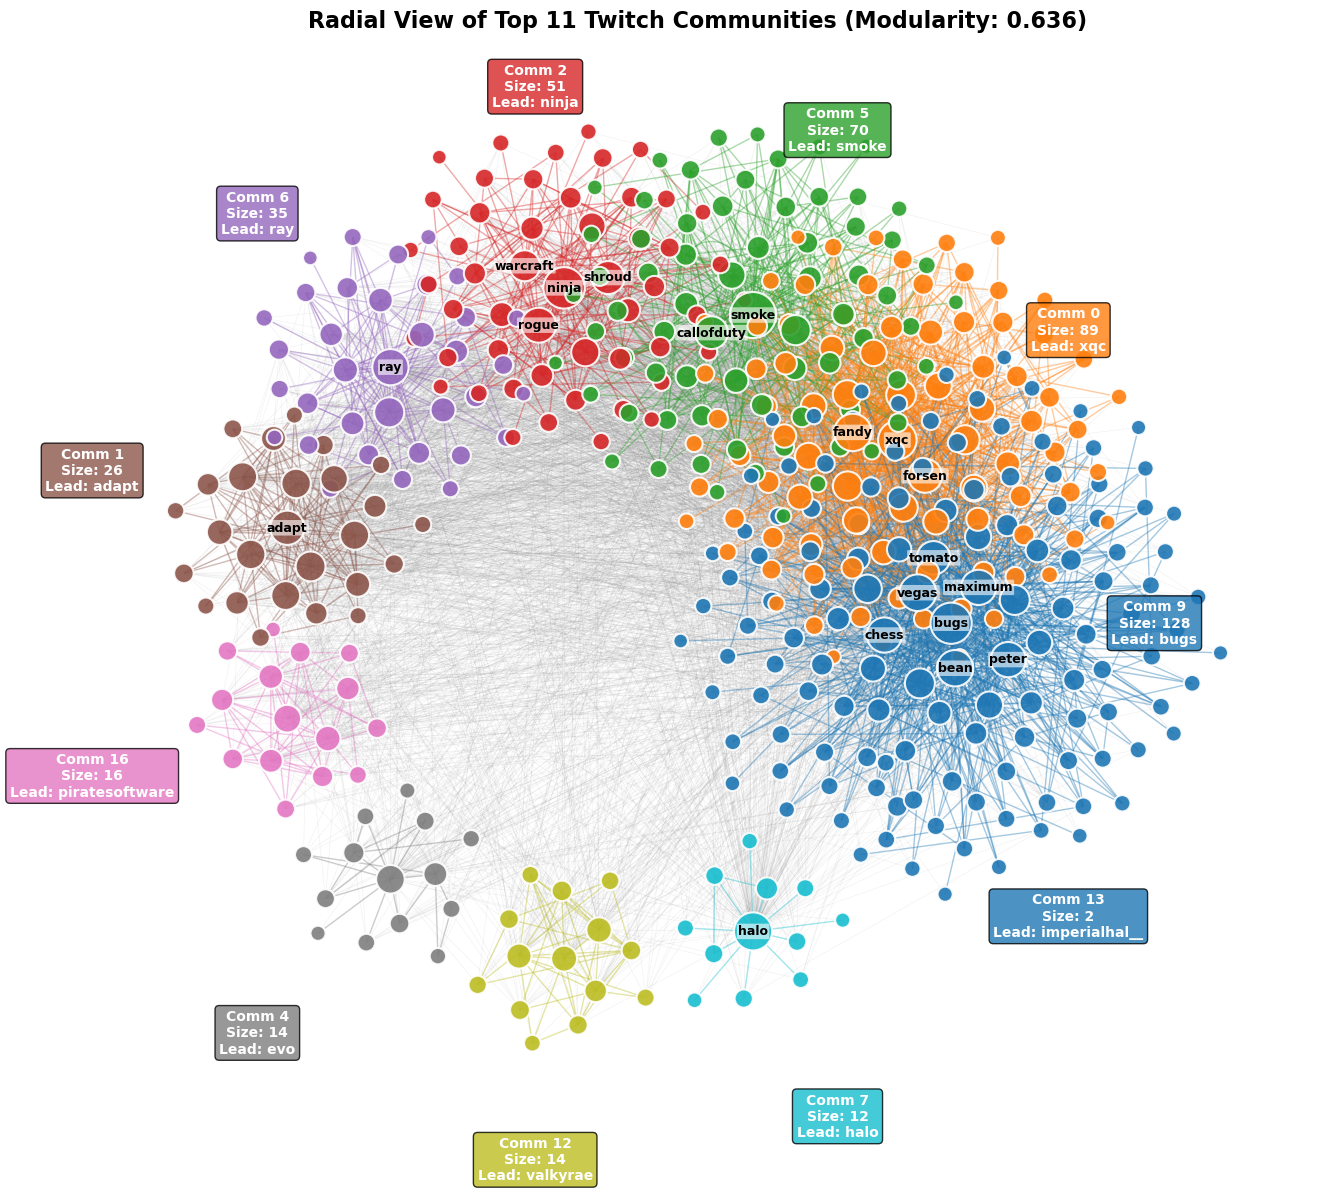

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 1. Convert partition (node->id) to community dict (id->[nodes])
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

def visualize_radial_communities(G, partition, communities, title, top_n_communities=11):
    """
    Visualize communities in a radial structure.
    """
    plt.figure(figsize=(15, 12))
    ax = plt.gca()
    
    # Sort communities by size
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    top_community_data = sorted_communities[:top_n_communities]
    top_community_ids = [c_id for c_id, _ in top_community_data]
    
    # Create subgraphs
    nodes_to_include = []
    for _, members in top_community_data:
        nodes_to_include.extend(members)
    
    H = G.subgraph(nodes_to_include).copy()
    
    # Calculate degrees for node sizing
    degrees = dict(H.degree())
    
    # --- Step 1: calculate positions (Spiral Layout) ---
    pos = {}
    n_communities = len(top_community_data)
    
    for comm_idx, (comm_id, members) in enumerate(top_community_data):
        # 1. Find centrum of this cluster (evenly spaced in a circle)
        base_angle = 2 * np.pi * comm_idx / n_communities
        cluster_distance = 3.0 # Distance from center of plot to cluster
        cluster_center_x = cluster_distance * np.cos(base_angle)
        cluster_center_y = cluster_distance * np.sin(base_angle)
        
        # 2. Sort members by degree (leader first)
        sorted_members = sorted(members, key=lambda x: degrees.get(x, 0), reverse=True)
        
        # 3. Placer nodes in a spiral around cluster center
        for i, node in enumerate(sorted_members):
            if i == 0:
                # Leader (Hub) exactly in the center
                pos[node] = (cluster_center_x, cluster_center_y)
            else:
                # other nodes spiral outward
                radius_step = 0.20 # Distance between rings
                angle_step = 2.4   # Golden angle approx
                
                ring = int(np.sqrt(i)) 
                radius = 0.2 + ring * radius_step
                angle = (i * angle_step) + base_angle
                
                pos[node] = (
                    cluster_center_x + radius * np.cos(angle),
                    cluster_center_y + radius * np.sin(angle)
                )

    # --- Step 2: Draw nodes and edges ---
    
    # colors
    color_list = plt.cm.tab10.colors
    node_colors = []
    for node in H.nodes():
        comm_id = partition[node]
        # Find color index based on top_community_ids order
        color_idx = top_community_ids.index(comm_id) % len(color_list)
        node_colors.append(color_list[color_idx])

    # Node sizes
    max_degree = max(degrees.values()) if degrees else 1
    node_sizes = [100 + (degrees[n] / max_degree) ** 0.8 * 1000 for n in H.nodes()]

    # Draw Edges
    # A. Inter-community (between groups) - very faint
    inter_edges = [(u, v) for u, v in H.edges() if partition[u] != partition[v]]
    nx.draw_networkx_edges(H, pos, edgelist=inter_edges, ax=ax, 
                          alpha=0.1, edge_color='gray', width=0.5)
    
    # B. Intra-community (internally in group) - colored
    intra_edges = [(u, v) for u, v in H.edges() if partition[u] == partition[v]]
    # Find color for each intra edge (use node color)
    intra_colors = []
    for u, v in intra_edges:
        c_id = partition[u]
        c_idx = top_community_ids.index(c_id) % len(color_list)
        intra_colors.append(color_list[c_idx])
        
    nx.draw_networkx_edges(H, pos, edgelist=intra_edges, ax=ax, 
                          alpha=0.4, edge_color=intra_colors, width=1.0)

    # Draw Nodes
    nx.draw_networkx_nodes(H, pos, ax=ax, node_color=node_colors, 
                          node_size=node_sizes, alpha=0.9,
                          edgecolors='white', linewidths=1.5)

    # --- Step 3: Annotations ---
    
    # Labels of nodes and communities
    large_node_labels = {}
    for node in H.nodes():
        # Show label only if node is top 30% important in whole graph or top 1 in its community
        if degrees[node] > max_degree * 0.3: 
            large_node_labels[node] = node
            
    nx.draw_networkx_labels(H, pos, labels=large_node_labels, font_size=9, 
                            font_weight='bold', font_color='black',
                            bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.6))

    # B. Big Community Labels 
    for comm_idx, (comm_id, members) in enumerate(top_community_data):
        # Find position for label (a bit further out than cluster)
        base_angle = 2 * np.pi * comm_idx / n_communities
        label_dist = 4.8
        lx = label_dist * np.cos(base_angle)
        ly = label_dist * np.sin(base_angle)
        
        # Find top streamer name (leader)
        leader = sorted(members, key=lambda x: degrees.get(x, 0), reverse=True)[0]
        
        # Infobox
        info_text = f"Comm {comm_id}\nSize: {len(members)}\nLead: {leader}"
        
        ax.text(lx, ly, info_text, fontsize=10, fontweight='bold',
                ha='center', va='center',
                bbox=dict( 
                          facecolor=color_list[comm_idx % len(color_list)], 
                          edgecolor='black', alpha=0.8, boxstyle="round"),
                color='white')

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    # Make sure circles are round (not oval)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Visualize the top 11 communities
visualize_radial_communities(G_undir, partition, communities, 
                            title=f"Radial View of Top 11 Twitch Communities (Modularity: {modularity:.3f})", 
                            top_n_communities=11)